<a href="https://colab.research.google.com/github/GiLberT-Mak/FYP_MU/blob/main/FYP_SNN_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# cell 1: SETUP
!pip install snntorch
!pip install torch

In [1]:
import torch
import torch.nn as nn
import snntorch as snn
import numpy as np
import h5py
import pandas as pd
import os
import glob
import sys
import matplotlib.pyplot as plt

# ==========================================
# 1. CONFIGURATION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Running on: {device}")

# PORJECT PATHS
PROJECT_PATH = '/content/drive/My Drive/HKMU_FYP'
DATA_ROOT = os.path.join(PROJECT_PATH, 'All_Subjects')

# MODEL PARAMETERS
NUM_INPUTS = 16       # 16 Channels
NUM_OUTPUTS = 8       # Classes (Grasps)
NUM_STEPS = 100       # Time Window
BATCH_SIZE = 64
LEARNING_RATE = 0.002
EPOCHS = 200          # Train longer because we have more data now

⚙️ Running on: cuda


In [2]:
# ==========================================
# 2. THE MULTI-SUBJECT LOADER
# ==========================================
class PairedLoader:
    def __init__(self, root_dir):
        self.sessions = []

        # 1. Scan for folders
        if not os.path.exists(root_dir):
            print(f"❌ Error: Folder not found: {root_dir}")
            sys.exit()

        subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]
        print(f"\n📂 Scanning {len(subfolders)} folders for valid pairs...")

        # 2. Validate Pairs
        for folder in subfolders:
            # Find .hdf5 and .csv inside this folder
            h5_files = glob.glob(os.path.join(folder, "*.hdf5"))
            csv_files = glob.glob(os.path.join(folder, "*.csv"))

            folder_name = os.path.basename(folder)

            if len(h5_files) > 0 and len(csv_files) > 0:
                # PAIR FOUND
                try:
                    f = h5py.File(h5_files[0], 'r')
                    meta = pd.read_csv(csv_files[0])

                    # Store Logic
                    session = {
                        'name': folder_name,
                        'file': f,
                        'keys': list(f.keys()),
                        'meta': meta,
                        'label_col': None,
                        'shift': 0
                    }

                    # Auto-detect Label Column
                    for col in ['grasp', 'class', 'label', 'stimulus', 'target']:
                        if col in meta.columns:
                            session['label_col'] = col
                            break
                    if session['label_col'] is None:
                        session['label_col'] = meta.columns[-1] # Fallback

                    # Check Label Shift (if labels are 1-8, shift to 0-7)
                    if meta[session['label_col']].min() > 0:
                        session['shift'] = -1

                    self.sessions.append(session)
                    print(f"   ✅ [LOADED] {folder_name} | Labels: '{session['label_col']}' | Samples: {len(session['keys'])}")

                except Exception as e:
                    print(f"   ⚠️ [ERROR] {folder_name}: {e}")
            else:
                print(f"   ⚠️ [SKIP] {folder_name} (Missing .hdf5 or .csv)")

        if len(self.sessions) == 0:
            print("\n❌ CRITICAL ERROR: No valid data pairs found.")
            sys.exit()

        print(f"\n🎉 Ready to train on {len(self.sessions)} Subjects!")

    def get_batch(self, batch_size=32):
        inputs = []
        targets = []

        for _ in range(batch_size):
            # A. Randomly select ONE Subject from the list
            sess = np.random.choice(self.sessions)

            # B. Randomly select ONE Trial from that Subject
            key_str = np.random.choice(sess['keys'])

            # C. Get Label
            try:
                row_idx = int(key_str)
                raw_val = sess['meta'].iloc[row_idx][sess['label_col']]
                label = int(raw_val) + sess['shift']
                label = max(0, min(label, NUM_OUTPUTS - 1))
            except:
                continue

            # D. Get Signal
            data = np.array(sess['file'][key_str])
            if data.shape[0] == NUM_INPUTS: data = data.T

            # E. Slice & Normalize
            if data.shape[0] > NUM_STEPS:
                start = np.random.randint(0, data.shape[0] - NUM_STEPS)
                snippet = data[start:start+NUM_STEPS, :]
            else:
                snippet = np.zeros((NUM_STEPS, NUM_INPUTS))
                snippet[:data.shape[0], :] = data

            # Normalization (0-2 range)
            snippet = snippet / (np.max(np.abs(snippet)) + 1e-6) * 2.0

            inputs.append(snippet)
            targets.append(label)

        return (torch.tensor(np.array(inputs), dtype=torch.float).permute(1,0,2).to(device),
                torch.tensor(np.array(targets), dtype=torch.long).to(device))

In [3]:
# ==========================================
# 3. ADVANCED ARCHITECTURE: RECURRENT SNN (FIXED)
# ==========================================
class ProstheticSNN(nn.Module):
    def __init__(self):
        super().__init__()

        # 1. Hyperparameters
        beta_init = 0.9
        hidden_size = 128  # Define hidden size here for consistency

        # 2. Input Layer
        self.fc1 = nn.Linear(NUM_INPUTS, hidden_size)

        # 3. Recurrent Layer (The Upgrade)
        # FIX: Added 'linear_features=hidden_size' so it knows the size of the feedback loop
        self.rlif1 = snn.RLeaky(
            beta=beta_init,
            learn_beta=True,
            all_to_all=True,
            linear_features=hidden_size  # <--- THIS WAS MISSING
        )

        # 4. Dropout
        self.dropout = nn.Dropout(0.5)

        # 5. Output Layer
        self.fc2 = nn.Linear(hidden_size, NUM_OUTPUTS)
        self.lif2 = snn.Leaky(beta=beta_init, learn_beta=True)

    def forward(self, x):
        # Initialize Memories
        spk1, mem1 = self.rlif1.init_rleaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []

        # Temporal Loop
        for step in range(x.size(0)):
            # Input -> Linear
            cur1 = self.fc1(x[step])

            # Linear -> Recurrent SNN
            spk1, mem1 = self.rlif1(cur1, spk1, mem1)

            # Dropout
            spk1_drop = self.dropout(spk1)

            # Output
            cur2 = self.fc2(spk1_drop)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0)


📂 Scanning 6 folders for valid pairs...
   ✅ [LOADED] Subject_01 | Labels: 'grasp' | Samples: 150
   ✅ [LOADED] Subject_02 | Labels: 'grasp' | Samples: 150
   ✅ [LOADED] Subject_03 | Labels: 'grasp' | Samples: 150
   ✅ [LOADED] Subject_04 | Labels: 'grasp' | Samples: 150
   ✅ [LOADED] Subject_05 | Labels: 'grasp' | Samples: 150
   ⚠️ [SKIP] Subject_06 (Missing .hdf5 or .csv)

🎉 Ready to train on 5 Subjects!

🚀 Starting Smart Training on 5 Subjects...
   (Saving only when accuracy improves...)
   Epoch 0 | Loss: 9.12 | Acc: 0.0%
   Epoch 5 | Loss: 4.07 | Acc: 10.9%  --> ⭐ NEW BEST! Saved.
   Epoch 10 | Loss: 3.06 | Acc: 14.1%  --> ⭐ NEW BEST! Saved.
   Epoch 15 | Loss: 2.08 | Acc: 9.4%
   Epoch 20 | Loss: 1.76 | Acc: 28.1%  --> ⭐ NEW BEST! Saved.
   Epoch 25 | Loss: 1.86 | Acc: 29.7%  --> ⭐ NEW BEST! Saved.
   Epoch 30 | Loss: 1.75 | Acc: 29.7%
   Epoch 35 | Loss: 1.84 | Acc: 28.1%
   Epoch 40 | Loss: 1.87 | Acc: 28.1%
   Epoch 45 | Loss: 1.70 | Acc: 37.5%  --> ⭐ NEW BEST! Saved.
   Ep

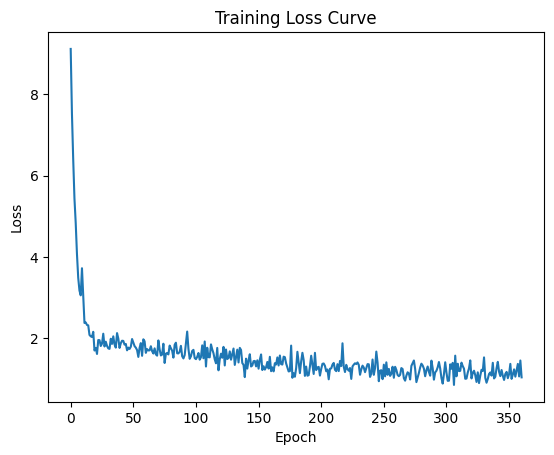

In [4]:
# ==========================================
# 4. SMART TRAINING LOOP (Saves Best Model)
# ==========================================
def run_smart_training():
    # 1. Initialize the Loader (Scans your 5 Subject Folders)
    loader = PairedLoader(DATA_ROOT)

    # 2. Initialize Model & Optimizer
    net = ProstheticSNN().to(device)

    # Use Weight Decay (1e-4) to prevent overfitting
    optimizer = torch.optim.Adam(net.parameters(), lr=0.002, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    print(f"\n🚀 Starting Smart Training on {len(loader.sessions)} Subjects...")
    print("   (Saving only when accuracy improves...)")

    loss_hist = []
    best_acc = 0.0 # Track the high score

    # 3. Loop for 300 Epochs (Optimal for 5 subjects)
    for epoch in range(301):

        # --- TRAINING PHASE ---
        net.train() # Enable Dropout
        data, targets = loader.get_batch(BATCH_SIZE)

        spk_rec = net(data)
        loss = loss_fn(spk_rec.sum(dim=0), targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss.item())

        # --- VALIDATION PHASE (Every 10 Epochs) ---
        if epoch % 5 == 0:
            net.eval() # Disable Dropout for fair testing
            with torch.no_grad():
                # Get a fresh batch to test generalization
                val_data, val_targets = loader.get_batch(BATCH_SIZE)
                spk_val = net(val_data)

                # Calculate Accuracy
                _, pred = torch.max(spk_val.sum(dim=0), 1)
                acc = (pred == val_targets).float().mean() * 100

            print(f"   Epoch {epoch} | Loss: {loss.item():.2f} | Acc: {acc:.1f}%", end="")

            # --- THE SMART SAVE ---
            if acc > best_acc:
                best_acc = acc
                save_path = os.path.join(PROJECT_PATH, 'snn_brain_best.pth')
                torch.save(net.state_dict(), save_path)
                print(f"  --> ⭐ NEW BEST! Saved.")
            else:
                print("") # New line

    print("\n" + "="*40)
    print(f"✅ Training Complete.")
    print(f"🏆 Best Accuracy Achieved: {best_acc:.1f}%")
    print(f"💾 Model Location: {os.path.join(PROJECT_PATH, 'snn_brain_best.pth')}")
    print("="*40)

    # Plot Loss
    plt.plot(loss_hist)
    plt.title("Training Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

if __name__ == "__main__":
    run_smart_training()

## **TESTER**


⚙️ Running on: cuda
📂 Loaded Test Data: 150 samples.
🧠 Loading Recurrent Brain from: snn_brain_best.pth
⚡ Testing on 150 samples...

🏆 FINAL TEST ACCURACY: 37.33%


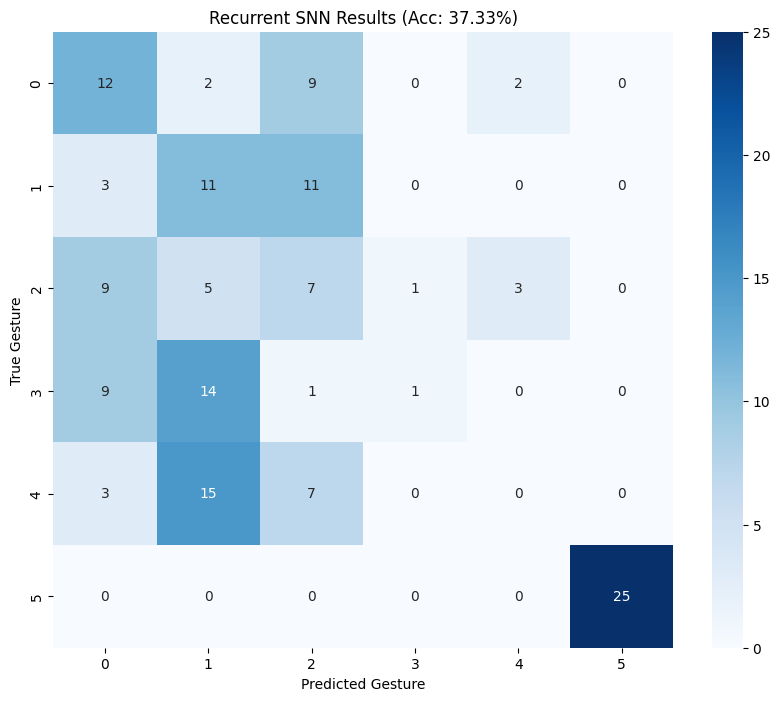

In [5]:
import torch
import torch.nn as nn
import snntorch as snn
import numpy as np
import h5py
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# ==========================================
# 1. CONFIGURATION
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚙️ Running on: {device}")

# PORJECT PATHS
PROJECT_PATH = '/content/drive/My Drive/HKMU_FYP'
TEST_FOLDER = os.path.join(PROJECT_PATH, 'Test_Subject')

# FILES
TEST_H5 = 'emg_test.hdf5'
TEST_CSV = 'trials_test.csv'
MODEL_FILE = 'snn_brain_best.pth' # Loading the best model from smart training

# MODEL PARAMS
NUM_INPUTS = 16
NUM_OUTPUTS = 8
NUM_STEPS = 100
HIDDEN_SIZE = 128

# ==========================================
# 2. TEST LOADER (Standard)
# ==========================================
class FixedTestLoader:
    def __init__(self, folder, h5_name, csv_name):
        h5_path = os.path.join(folder, h5_name)
        csv_path = os.path.join(folder, csv_name)

        if not os.path.exists(h5_path) or not os.path.exists(csv_path):
            print(f"❌ Error: Files not found in {folder}")
            self.keys = []
            return

        self.f = h5py.File(h5_path, 'r')
        self.keys = list(self.f.keys())
        self.meta = pd.read_csv(csv_path)

        # Detect Label Column
        self.label_col = None
        for col in ['grasp', 'class', 'label', 'stimulus']:
            if col in self.meta.columns:
                self.label_col = col
                break
        if self.label_col is None: self.label_col = self.meta.columns[-1]

        # Detect Shift
        self.shift = -1 if self.meta[self.label_col].min() > 0 else 0
        print(f"📂 Loaded Test Data: {len(self.keys)} samples.")

    def get_all_data(self):
        inputs = []
        targets = []

        for key in self.keys:
            try:
                # Get Label
                row_idx = int(key)
                raw_val = self.meta.iloc[row_idx][self.label_col]
                label = int(raw_val) + self.shift
                label = max(0, min(label, NUM_OUTPUTS - 1))

                # Get Signal
                data = np.array(self.f[key])
                if data.shape[0] == NUM_INPUTS: data = data.T

                # Slice Center
                if data.shape[0] > NUM_STEPS:
                    mid = data.shape[0] // 2
                    snippet = data[mid:mid+NUM_STEPS, :]
                else:
                    snippet = np.zeros((NUM_STEPS, NUM_INPUTS))
                    snippet[:data.shape[0], :] = data

                # Normalize
                snippet = snippet / (np.max(np.abs(snippet)) + 1e-6) * 2.0

                inputs.append(snippet)
                targets.append(label)
            except:
                continue

        # Returns [Batch, Time, Channels]
        return (torch.tensor(np.array(inputs), dtype=torch.float),
                np.array(targets))

# ==========================================
# 3. MODEL ARCHITECTURE (MUST MATCH TRAINING)
# ==========================================
class ProstheticSNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 1
        self.fc1 = nn.Linear(NUM_INPUTS, HIDDEN_SIZE)

        # Recurrent Layer (The Upgrade)
        self.rlif1 = snn.RLeaky(
            beta=0.9,
            learn_beta=True,
            all_to_all=True,
            linear_features=HIDDEN_SIZE # <--- Crucial line
        )

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Layer 2
        self.fc2 = nn.Linear(HIDDEN_SIZE, NUM_OUTPUTS)
        self.lif2 = snn.Leaky(beta=0.9, learn_beta=True)

    def forward(self, x):
        # Init Memories
        spk1, mem1 = self.rlif1.init_rleaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []

        for step in range(x.size(0)):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.rlif1(cur1, spk1, mem1)
            spk1_drop = self.dropout(spk1)
            cur2 = self.fc2(spk1_drop)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)

        return torch.stack(spk2_rec, dim=0)

# ==========================================
# 4. RUN TEST
# ==========================================
def run_final_test():
    # 1. Load Data
    loader = FixedTestLoader(TEST_FOLDER, TEST_H5, TEST_CSV)
    if not loader.keys: return
    inputs, true_labels = loader.get_all_data()

    # 2. Load Model
    net = ProstheticSNN().to(device)
    model_path = os.path.join(PROJECT_PATH, MODEL_FILE)

    if os.path.exists(model_path):
        print(f"🧠 Loading Recurrent Brain from: {MODEL_FILE}")
        net.load_state_dict(torch.load(model_path, map_location=device))
        net.eval()
    else:
        print(f"❌ Error: {MODEL_FILE} not found. Did you run the smart training?")
        return

    # 3. Inference Loop
    print(f"⚡ Testing on {len(true_labels)} samples...")
    predicted_labels = []
    batch_size = 64

    with torch.no_grad():
        for i in range(0, len(inputs), batch_size):
            # Move batch to GPU
            batch = inputs[i : i+batch_size].to(device)
            # Permute for SNN [Time, Batch, Channels]
            batch = batch.permute(1, 0, 2)

            spk_out = net(batch)

            # Decode
            _, pred = torch.max(spk_out.sum(dim=0), 1)
            predicted_labels.extend(pred.cpu().numpy())

    # 4. Results
    acc = accuracy_score(true_labels, predicted_labels) * 100
    print(f"\n🏆 FINAL TEST ACCURACY: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Recurrent SNN Results (Acc: {acc:.2f}%)")
    plt.xlabel("Predicted Gesture")
    plt.ylabel("True Gesture")
    plt.show()

if __name__ == "__main__":
    run_final_test()